In [1]:
# Note: many variables are named "dA2" when they really represent 2A2(2A^2) 
# because the names of python variables cannot begin with a number.

import pandas as pd
import math
from math import comb
from matplotlib import pyplot as plt
import time
from ast import literal_eval
from sys import getsizeof
import cmath

In [2]:
n = 3000000

is_prime = [False, False] + [True] * (n - 1)
primes = [2]

for j in range(4, n + 1, 2):
    is_prime[j] = False

for i in range(3, n + 1, 2):
    if is_prime[i]:
        primes.append(i)
        for j in range(i * i, n + 1, i):
            is_prime[j] = False

primes_3mod4 = []
for q in primes:
    if q%4 == 3:
        primes_3mod4.append(q)

In [3]:
def findPrimes3mod4(q_min, q_max):
    q_cand = []
    for q in primes_3mod4:
        if q >= q_min and q <= q_max:
            q_cand.append(q)
    return q_cand

In [5]:
def addmod(a, b, q):
    c = a + b
    y = complex(round((c/q).real),round((c/q).imag))
    p = c-q*y
    return p

def mulmod(a, b, q):
    c = a*b
    y = complex(round((c/q).real),round((c/q).imag))
    p = c-q*y
    return p

In [6]:
# Given a number q and a power, return a list of divisors > q^0.5 and <= 1.2q^0.5 [method 5]
def findDivisors(q_, power):
    divisors = []
    q = q_+1
    threshold = math.ceil(q**power)
    for i in range(threshold+1, int(threshold*1.2)+1): # 1.2
        if q_%i == 0:
            divisors.append(i)
    return divisors

In [7]:
def calMax(n):
    return comb(n, 2)+2*n

In [8]:
# param:
# q: |G|
# g: the generator
def generateCyclicGroup(q, g, n):
    cyclicGroup = [g]
    a = g
    while a != 1:
        a = mulmod(a, g, q)
        cyclicGroup.append(a)
        if len(cyclicGroup) == n:
            return cyclicGroup
    return cyclicGroup

In [9]:
def compute2A2(A, q):
    twoA2_set = set()
    for a1 in A:
        for a2 in A:
            twoa2 = addmod(a1, a2, q)
            twoA2_set.add(twoa2)
    twoA2 = list(twoA2_set)
    return twoA2

In [10]:
# param:
# mulG: G*
# n: one possible order of multiplicative subgroups. Divides |G| = q
def findMulSubgroup(q, n):
    err = [[False]*q for count in range(q)]
    for a in range(1, q):
        for b in range(1, q):
            g = complex(a, b)
            if err[a][b] == False:
                cyclicGroup = generateCyclicGroup(q, g, n)
                if len(cyclicGroup) == n and cyclicGroup[len(cyclicGroup)-1] == 1:
                    return cyclicGroup
                elif len(cyclicGroup) < n:
                    for index in range(len(cyclicGroup)-1):
                        c = cyclicGroup[index]
                        err[int(c.real)][int(c.imag)] = True
    return []

In [11]:
def structured_results(lists):
    # general info and stats
    validSubgroups_list, invalidSubgroups_list, worstCases_list, stat_list = lists
    col = ["q","|A|","A","|2A^2|","(|A| 2)","|2A^2|/(|A| 2)","|2A^2|/q"]
    validSubgroups = pd.DataFrame(validSubgroups_list, columns = col) # info of valid subgroups
    invalidSubgroups = pd.DataFrame(invalidSubgroups_list, columns = col) # info of invalid subrgoups
    worstCases = pd.DataFrame(worstCases_list, columns = col)
    validSubgroups.to_csv("validSubgroupsUnder1thousand.csv", index=False)
    invalidSubgroups.to_csv("invalidSubgroupsUnder1thousand.csv", index=False)
    worstCases.to_csv("worstCasesUnder1thousand.csv", index=False)

    p00, p10, p20, p30, p40, p50, p60, p70, p80, p90, p50_, p = stat_list
    stat_list = [p00/p, p10/p, p20/p, p30/p, p40/p, p50/p, p60/p, p70/p, p80/p, p90/p, p50_/p]
    stat = pd.Series(stat_list, index=["0-10%","10-20%","20-30%","30-40%","40-50%","50-60%","60-70%","70-80%","80-90%","90-100%",">50%"]) # stats
    print("|2A^2|/q distribution")
    print(stat)
    
    results = {"validSubgroups":validSubgroups, "invalidSubgroups":invalidSubgroups, "worstCases":worstCases, "stats":stat}
    return results

In [12]:
# MAIN
# Find all multiplicative subgroups A of G with orders around q^0.5 and compute 2A^2. 
# If |2A^2|/(q-1)>0.5, add q,|A|,A,|2A^2|,2A^2,|2A^2|/q to the dataframe
# params:
# q_min, q_max: range of primes you want to use

def main1(q_min, q_max):
    q_cand = findPrimes3mod4(q_min, q_max)
    q_A_list = []
    for q in q_cand:
        p = q**2
        divisors = findDivisors(p-1, 1/2) # compute possible orders of multiplicative subgroups of G
        for divisor in divisors:
            print(q, p, divisor)
            start = time.time()
            A = findMulSubgroup(q, divisor) # find actual multiplicative subgroups A
            print(time.time() - start)
            q_A_list.append([q, A])
    return q_A_list 

In [13]:
def main2(q_A_list):
    p50_, p00, p10, p20, p30, p40, p50, p60, p70, p80, p90, p = (0 for i in range(12))
    validSubgroups_list, invalidSubgroups_list, worstCases_list = ([] for i in range(3))
    worstCaseRatio = 1
    worstCase = [None]*7
    curr_q = 0
    index = -1
    n = 1048576
    for q_A in q_A_list:
        q = q_A[0]
        A = q_A[1]
        index += 1
        if q != curr_q:
            curr_q = q
            if worstCase[0] != None:
                worstCases_list.append(worstCase)
                print("size1:",getsizeof(worstCases_list)/n)
            worstCaseRatio = 1
            worstCase = [None]*7
        if len(A) != 0:
            divisor = len(A)
            print("q:",q, "divisor:",divisor,"index:",p)
            p+=1
            start = time.time()
            dA2 = compute2A2(A, q) # compute 2A^2
            print(time.time() - start)
            length = len(dA2)
            pctg = length/(q**2)
            bestCase = calMax(divisor)
            if bestCase >= q**2:
                bestCase = q**2
            currentCaseRatio = length/bestCase
            if currentCaseRatio < worstCaseRatio:
                worstCaseRatio = currentCaseRatio
                worstCase = [q, divisor, A, length, bestCase, currentCaseRatio, pctg]
            if pctg >= 0.5: # check if 2A^2 is large enough (> |G|/2)
                p50_+=1
                validSubgroups_list.append([q, divisor, A, length, bestCase, currentCaseRatio, pctg]) # document valid multiplicative subgroups and stats
                print("size2:",getsizeof(validSubgroups_list)/n)
                if pctg < 0.6:
                    p50+=1
                elif pctg < 0.7:
                    p60+=1
                elif pctg < 0.8:
                    p70+=1
                elif pctg < 0.9:
                    p80+=1
                else:
                    p90+=1
            else:
                invalidSubgroups_list.append([q, divisor, A, length, bestCase, currentCaseRatio, pctg]) # document invalid ones
                print("size3:",getsizeof(invalidSubgroups_list)/n)
                if pctg >= 0.4:
                    p40+=1
                elif pctg >= 0.3:
                    p30+=1
                elif pctg >= 0.2:
                    p20+=1
                elif pctg >= 0.1:
                    p10+=1
                else:
                    p00+=1
        if (index+1) == len(q_A_list) and worstCase[0] != None:
            worstCases_list.append(worstCase)
            
    stat_list = [p00, p10, p20, p30, p40, p50, p60, p70, p80, p90, p50_, p]
    results = {"validSubgroups":validSubgroups_list, "invalidSubgroups":invalidSubgroups_list, "worstCases":worstCases_list, "stats":stat_list}
    return results

In [14]:
qA = main1(0, 1000)

7 49 8
0.007408618927001953
11 121 12
0.0
19 361 20
0.006981849670410156
23 529 24
0.001993417739868164
31 961 32
0.000997781753540039
43 1849 44
0.00401616096496582
47 2209 48
0.008943319320678711
59 3481 60
0.03889608383178711
67 4489 68
0.010970354080200195
71 5041 72
0.06682229042053223
71 5041 80
0.031914472579956055
71 5041 84
0.021941184997558594
79 6241 80
0.00897526741027832
83 6889 84
0.016954898834228516
103 10609 104
0.012965202331542969
107 11449 108
0.03091740608215332
127 16129 128
0.02293848991394043
127 16129 144
0.0019948482513427734
131 17161 132
0.04388260841369629
131 17161 143
0.007979154586791992
131 17161 156
0.004986286163330078
139 19321 140
0.05086374282836914
139 19321 161
0.007978677749633789
151 22801 152
0.03541135787963867
163 26569 164
0.06482601165771484
167 27889 168
0.3459188938140869
179 32041 180
0.35804224014282227
191 36481 192
0.20149850845336914
191 36481 228
0.05147671699523926
199 39601 200
0.04694509506225586
199 39601 220
0.1585428714752197

In [16]:
mulSubgroups = pd.DataFrame(qA, columns = ["q", "A"])
mulSubgroups.to_csv("mulSubGofZqi.csv", index=False)

In [17]:
mulSubgroups

,q,A
0,7,"[(2+2j), 1j, (-2+2j), (-1+0j), (-2-2j), -1j, (..."
1,11,"[(3+5j), (-5-3j), -1j, (5-3j), (-3+5j), (-1+0j..."
2,19,"[(3+7j), (-2+4j), (4-2j), (7+3j), 1j, (-7+3j),..."
3,23,"[(4+10j), (8+11j), (-9+9j), (-11-8j), (-10-4j)..."
4,31,"[(2+11j), (7+13j), (-5+10j), (4-4j), (-10+5j),..."
...,...,...
153,983,"[(4+70j), (31-423j), (244+478j), (-45+315j), (..."
154,991,"[(2+227j), (7-83j), (26+432j), (97-171j), (362..."
155,991,"[(3+149j), (-390-97j), (400+68j), (-13+344j), ..."
156,991,"[(2+56j), (-159+224j), (21+463j), (-120+120j),..."


In [18]:
results = main2(qA)

q: 7 divisor: 8 index: 0
0.0
size2: 4.1961669921875e-05
size1: 4.1961669921875e-05
q: 11 divisor: 12 index: 1
0.0
size2: 4.1961669921875e-05
size1: 4.1961669921875e-05
q: 19 divisor: 20 index: 2
0.0
size2: 4.1961669921875e-05
size1: 4.1961669921875e-05
q: 23 divisor: 24 index: 3
0.001123189926147461
size2: 4.1961669921875e-05
size1: 4.1961669921875e-05
q: 31 divisor: 32 index: 4
0.0009980201721191406
size2: 5.7220458984375e-05
size1: 5.7220458984375e-05
q: 43 divisor: 44 index: 5
0.002500295639038086
size2: 5.7220458984375e-05
size1: 5.7220458984375e-05
q: 47 divisor: 48 index: 6
0.0019953250885009766
size2: 5.7220458984375e-05
size1: 5.7220458984375e-05
q: 59 divisor: 60 index: 7
0.003989219665527344
size2: 5.7220458984375e-05
size1: 5.7220458984375e-05
q: 67 divisor: 68 index: 8
0.005984306335449219
size2: 8.7738037109375e-05
size1: 8.7738037109375e-05
q: 71 divisor: 72 index: 9
0.004985809326171875
size2: 8.7738037109375e-05
q: 71 divisor: 80 index: 10
0.006981372833251953
size3: 4.

0.48483896255493164
size3: 0.00016021728515625
q: 599 divisor: 650 index: 90
0.5670568943023682
size3: 0.00016021728515625
q: 599 divisor: 690 index: 91
0.5919649600982666
size3: 0.00016021728515625
size1: 0.000247955322265625
q: 607 divisor: 608 index: 92
0.4349708557128906
size2: 0.000301361083984375
size1: 0.000247955322265625
q: 619 divisor: 620 index: 93
0.4617609977722168
size2: 0.000301361083984375
size1: 0.000247955322265625
q: 631 divisor: 632 index: 94
0.4721558094024658
size2: 0.000301361083984375
q: 631 divisor: 711 index: 95
0.5925662517547607
size3: 0.00016021728515625
q: 631 divisor: 720 index: 96
0.6797728538513184
size3: 0.000202178955078125
size1: 0.000301361083984375
q: 643 divisor: 644 index: 97
0.5136277675628662
size2: 0.000301361083984375
q: 643 divisor: 749 index: 98
0.6975820064544678
size3: 0.000202178955078125
size1: 0.000301361083984375
q: 647 divisor: 648 index: 99
0.49271512031555176
size2: 0.000301361083984375
q: 647 divisor: 684 index: 100
0.591081857681

In [19]:
results_list = results
lists =  [results_list["validSubgroups"], results_list["invalidSubgroups"],results_list["worstCases"],results_list["stats"]]
results = structured_results(lists)

|2A^2|/q distribution
0-10%      0.000000
10-20%     0.000000
20-30%     0.000000
30-40%     0.069620
40-50%     0.367089
50-60%     0.550633
60-70%     0.012658
70-80%     0.000000
80-90%     0.000000
90-100%    0.000000
>50%       0.563291
dtype: float64


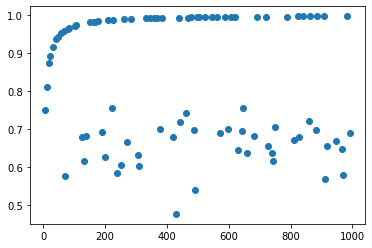

In [20]:
x = results["worstCases"]["q"]
y = results["worstCases"]["|2A^2|/(|A| 2)"]
plt.scatter(x,y)